In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import itertools
from tqdm import tqdm
import feat_eng

%matplotlib inline

Using TensorFlow backend.


## Load files

In [3]:
train = pd.read_csv('../Challenge/train.csv')
label = pd.read_csv('../Challenge/challenge_output_data_training_file_nba_challenge.csv', sep=';')
train = pd.merge(train, label, on='ID')

train = feat_eng.add_tot_rebounds(train)
train = feat_eng.add_fg(train)
df_train, df_val = train_test_split(train, test_size=0.2, random_state=42)

print(df_train.shape, df_val.shape)

100%|██████████| 1440/1440 [02:13<00:00, 10.78it/s]

(10060, 21602) (2516, 21602)


## Logistic regression

In [4]:
y_train = df_train.label.values
X_train = df_train.drop(['ID', 'label'], axis=1)

y_val = df_val.label.values
X_val = df_val.drop(['ID', 'label'], axis=1)

In [5]:
from sklearn import datasets, neighbors, linear_model
import time
logistic = linear_model.LogisticRegression(C=0.00001, solver='newton-cg')

t = time.time()
logistic.fit(X_train, y_train)
elapsed = time.time() - t
print(elapsed)

195.97348713874817


In [6]:
y_pred = logistic.predict(X_val)
np.mean(y_pred == y_val)

0.72098569157392689

## Output on Test

In [9]:
test = pd.read_csv('../Challenge/test.csv')
test = feat_eng.add_tot_rebounds(test)
test = feat_eng.add_fg(test, test=True)
X_test = test.drop(['ID'], axis=1)
test['label'] = logistic.predict(X_test)
test[['ID', 'label']].to_csv('pred_logreg_opt_raw.csv', index=False)

100%|██████████| 1440/1440 [00:18<00:00, 78.84it/s]


## Feature Importance

In [100]:
sort_index = np.argsort(logistic.coef_[0])[::-1]
sort_index

array([21585, 21570, 21555, ...,  4665,  4605,  4620])

In [108]:
feat_names = X_train.columns[np.argsort(logistic.coef_[0])[::-1]]
feat = np.sort(logistic.coef_[0])[::-1]

In [109]:
all_features = set([k.split('_')[0] for k in feat_names])
feat_min_idx = sorted([min([i for i,k in enumerate(feat_names) if k.split('_')[0] == feat]) for feat in all_features])
feat_names2 = feat_names[feat_min_idx]
feat2 = feat[feat_min_idx]

In [110]:
def correct_label(x):
    x = x.replace('_','\n')
    x = x.replace("defensive", 'def')
    x = x.replace('offensive', 'off')
    return x.replace('total', '')

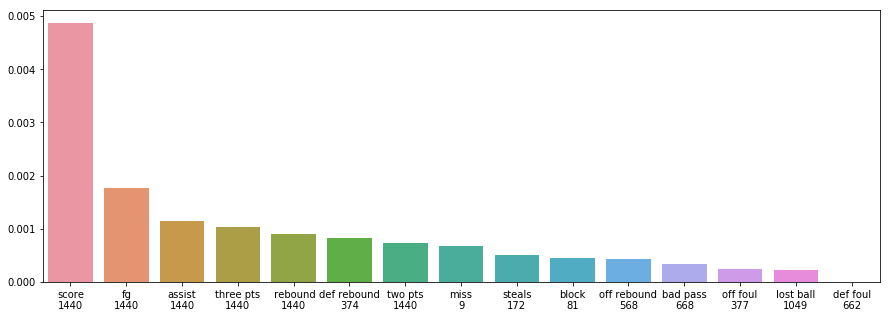

In [111]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=feat_names2, y=feat2, order=feat_names2)
_=ax.set_xticklabels([correct_label(k.get_text()) for k in ax.get_xticklabels()])